In [ ]:
code_file= 'sum.c'

In [ ]:
compatible_flags = [
    '-fauto-inc-dec', '-fbranch-count-reg', '-fcombine-stack-adjustments', '-fcompare-elim',
    '-fcprop-registers', '-fdce', '-fdefer-pop', '-fdelayed-branch', '-fdse', '-fforward-propagate',
    '-fguess-branch-probability', '-fif-conversion', '-fif-conversion2', '-finline-functions-called-once',
    '-fipa-modref', '-fipa-profile', '-fipa-pure-const', '-fipa-reference', '-fipa-reference-addressable',
    '-fmerge-constants', '-fmove-loop-invariants', '-fomit-frame-pointer', '-freorder-blocks', '-fshrink-wrap',
    '-fshrink-wrap-separate', '-fsplit-wide-types', '-fssa-backprop', '-fssa-phiopt', '-ftree-bit-ccp',
    '-ftree-ccp', '-ftree-ch', '-ftree-coalesce-vars', '-ftree-copy-prop', '-ftree-dce', '-ftree-dominator-opts',
    '-ftree-dse', '-ftree-forwprop', '-ftree-fre', '-ftree-phiprop', '-ftree-pta', '-ftree-scev-cprop', '-ftree-sink',
    '-ftree-slsr', '-ftree-sra', '-ftree-ter', '-funit-at-a-time', '-falign-functions', '-falign-jumps', '-falign-labels',
    '-falign-loops', '-fcaller-saves', '-fcode-hoisting', '-fcrossjumping', '-fcse-follow-jumps', '-fcse-skip-blocks',
    '-fdelete-null-pointer-checks', '-fdevirtualize', '-fdevirtualize-speculatively', '-fexpensive-optimizations',
    '-ffinite-loops', '-fgcse', '-fgcse-lm', '-fhoist-adjacent-loads', '-finline-functions', '-finline-small-functions',
    '-findirect-inlining', '-fipa-bit-cp', '-fipa-cp', '-fipa-icf', '-fipa-ra', '-fipa-sra', '-fipa-vrp',
    '-fisolate-erroneous-paths-dereference', '-flra-remat', '-foptimize-sibling-calls', '-foptimize-strlen',
    '-fpartial-inlining', '-fpeephole2', '-freorder-blocks-algorithm=stc', '-freorder-blocks-and-partition',
    '-freorder-functions', '-frerun-cse-after-loop', '-fschedule-insns', '-fschedule-insns2', '-fsched-interblock',
    '-fsched-spec', '-fstore-merging', '-fstrict-aliasing', '-fthread-jumps', '-ftree-builtin-call-dce',
    '-ftree-loop-vectorize', '-ftree-pre', '-ftree-slp-vectorize', '-ftree-switch-conversion', '-ftree-tail-merge',
    '-ftree-vrp', '-fvect-cost-model=very-cheap', '-fgcse-after-reload', '-fipa-cp-clone', '-floop-interchange',
    '-floop-unroll-and-jam', '-fpeel-loops', '-fpredictive-commoning', '-fsplit-loops', '-fsplit-paths',
    '-ftree-loop-distribution', '-ftree-partial-pre', '-funswitch-loops', '-fvect-cost-model=dynamic',
    '-fversion-loops-for-strides'
]

In [ ]:
class CompilerEnv:
    def __init__(self, code_path):
        self.code_path = code_path
        self.flags = compatible_flags
        self.state_space = len(self.flags)
        self.action_space = len(self.flags)
        self.current_state = tuple([0] * self.state_space)

    def reset(self):
        self.current_state = tuple([0] * self.state_space)
        return self.current_state

    def compile_and_measure(self, flags):
        flags_str = ' '.join([self.flags[i] for i, flag in enumerate(flags) if flag])
        compile_command = f"gcc {self.code_path} {flags_str} -o output"
        run_command = "./output"

        try:
            compile_result = subprocess.run(compile_command, shell=True, capture_output=True, text=True, timeout=10)
            if compile_result.returncode != 0:
                print("Compilation failed:", compile_result.stderr)
                return float('inf')

            subprocess.run(f"chmod +x output", shell=True)

            run_result = subprocess.run(run_command, shell=True, capture_output=True, text=True, timeout=10)
            if run_result.returncode != 0:
                print("Execution failed:", run_result.stderr)
                return float('inf')

            output_lines = run_result.stdout.strip().split('\n')
            execution_time = float(output_lines[-1])
            return execution_time

        except subprocess.TimeoutExpired:
            print("Execution timed out")
            return float('inf')

    def step(self, action):
        current_flags = list(self.current_state)
        current_flags[action] = 1 - current_flags[action]
        self.current_state = tuple(current_flags)

        execution_time = self.compile_and_measure(self.current_state)
        reward = -execution_time

        return self.current_state, reward, False

    def render(self):
        print(f"State: {self.current_state}")


In [ ]:
import numpy as np
import subprocess
import pickle
import os
from collections import deque
import random
import matplotlib.pyplot as plt
from google.colab import files

class DQNAgent:
    def __init__(self, state_space, action_space, learning_rate=0.001, discount_factor=0.99, exploration_rate=1.0,
                 exploration_decay=0.995, memory_size=1000, batch_size=32, target_update_frequency=10):
        self.state_space = state_space
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size

        # Initialize the main and target networks
        self.model = DQNetwork(state_space, action_space)
        self.target_model = DQNetwork(state_space, action_space)
        self.update_target_network()

        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

        self.target_update_frequency = target_update_frequency
        self.steps_done = 0

    def choose_action(self, state):
        # Implement epsilon-greedy action selection
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.action_space)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch from the replay buffer
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)

            # Compute the predicted Q-values for the current state
            q_values = self.model(state_tensor)
            q_value = q_values[0, action]

            # Compute the target Q-value
            with torch.no_grad():
                next_q_values = self.target_model(next_state_tensor)
                next_q_value = torch.max(next_q_values)

            # Set the target Q-value for the current action
            target = reward + (1 - done) * self.gamma * next_q_value

            # Compute the loss
            loss = self.loss_fn(q_value, target)

            # Perform a gradient descent step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        # Decay epsilon
        self.epsilon *= self.epsilon_decay

        # Update the target network periodically
        if self.steps_done % self.target_update_frequency == 0:
            self.update_target_network()

        self.steps_done += 1

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def save_model(self, path):
        """Saves the model parameters to a file."""
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        """Loads the model parameters from a file."""
        self.model.load_state_dict(torch.load(path))
        self.model.eval()  # Set the model to evaluation mode


In [ ]:
def train_dqn(agent, env, episodes=100, save_path='dqn_model.pth'):
    rewards = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_rewards = []

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            episode_rewards.append(reward)

            if done:
                break

        agent.replay()
        rewards.append(total_reward)
        min_reward = min(episode_rewards)
        max_reward = max(episode_rewards)
        avg_reward = np.mean(episode_rewards)

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Min Reward: {min_reward:.10f}, Max Reward: {max_reward:.10f}, Average Reward: {avg_reward}")

        # Optionally save the model at specific episodes
        # if (episode + 1) % 10 == 0:
        #     agent.save_model(f'dqn_model_episode_{episode + 1}.pth')

    # Save the final model
    agent.save_model(save_path)

    plt.figure(figsize=(10, 6))
    plt.plot(range(episodes), rewards, marker='o', linestyle='-')
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards')
    plt.title('Episodes vs. Total Rewards per Episode (DQN)')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.10f}'))
    plt.grid(True)
    plt.show()

# Example of running a DQN experiment
new_code_path = 'sum.c'  # Specify the path to your C program
env = CompilerEnv(new_code_path)
dqn_agent = DQNAgent(env.state_space, env.action_space)

train_dqn(dqn_agent, env, episodes=100, save_path='dqn_model.pth')


NameError: name 'DQNetwork' is not defined

In [ ]:
# Load the trained model
dqn_agent.load_model('dqn_model.pth')

# Optionally, continue training or evaluation
# train_dqn(dqn_agent, env, episodes=100)

# Evaluate the agent
state = env.reset()
done = False
while not done:
    action = dqn_agent.choose_action(state)
    next_state, reward, done = env.step(action)
    state = next_state


NameError: name 'dqn_agent' is not defined

Streaming output truncated to the last 5000 lines.

Compilation failed: cc1: fatal error: sum.c: No such file or directory
compilation terminated.

Compilation failed: cc1: fatal error: sum.c: No such file or directory
compilation terminated.

Compilation failed: cc1: fatal error: sum.c: No such file or directory
compilation terminated.

Compilation failed: cc1: fatal error: sum.c: No such file or directory
compilation terminated.

Compilation failed: cc1: fatal error: sum.c: No such file or directory
compilation terminated.

Compilation failed: cc1: fatal error: sum.c: No such file or directory
compilation terminated.

Compilation failed: cc1: fatal error: sum.c: No such file or directory
compilation terminated.

Compilation failed: cc1: fatal error: sum.c: No such file or directory
compilation terminated.

Compilation failed: cc1: fatal error: sum.c: No such file or directory
compilation terminated.

Compilation failed: cc1: fatal error: sum.c: No such file or directory
compilation t

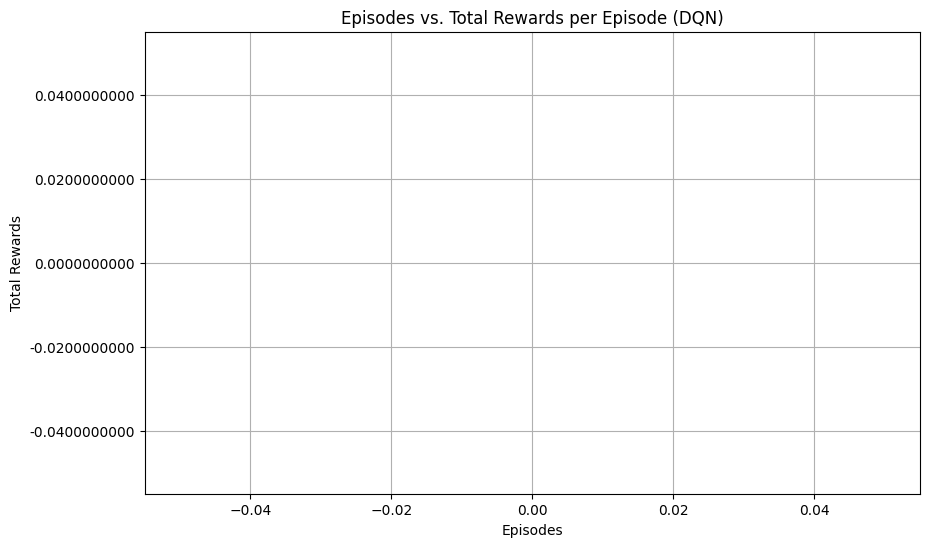

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import subprocess

# Define compatible flags for the compiler
compatible_flags = [
    '-fauto-inc-dec', '-fbranch-count-reg', '-fcombine-stack-adjustments', '-fcompare-elim',
    '-fcprop-registers', '-fdce', '-fdefer-pop', '-fdelayed-branch', '-fdse', '-fforward-propagate',
    '-fguess-branch-probability', '-fif-conversion', '-fif-conversion2', '-finline-functions-called-once',
    '-fipa-modref', '-fipa-profile', '-fipa-pure-const', '-fipa-reference', '-fipa-reference-addressable',
    '-fmerge-constants', '-fmove-loop-invariants', '-fomit-frame-pointer', '-freorder-blocks', '-fshrink-wrap',
    '-fshrink-wrap-separate', '-fsplit-wide-types', '-fssa-backprop', '-fssa-phiopt', '-ftree-bit-ccp',
    '-ftree-ccp', '-ftree-ch', '-ftree-coalesce-vars', '-ftree-copy-prop', '-ftree-dce', '-ftree-dominator-opts',
    '-ftree-dse', '-ftree-forwprop', '-ftree-fre', '-ftree-phiprop', '-ftree-pta', '-ftree-scev-cprop', '-ftree-sink',
    '-ftree-slsr', '-ftree-sra', '-ftree-ter', '-funit-at-a-time', '-falign-functions', '-falign-jumps', '-falign-labels',
    '-falign-loops', '-fcaller-saves', '-fcode-hoisting', '-fcrossjumping', '-fcse-follow-jumps', '-fcse-skip-blocks',
    '-fdelete-null-pointer-checks', '-fdevirtualize', '-fdevirtualize-speculatively', '-fexpensive-optimizations',
    '-ffinite-loops', '-fgcse', '-fgcse-lm', '-fhoist-adjacent-loads', '-finline-functions', '-finline-small-functions',
    '-findirect-inlining', '-fipa-bit-cp', '-fipa-cp', '-fipa-icf', '-fipa-ra', '-fipa-sra', '-fipa-vrp',
    '-fisolate-erroneous-paths-dereference', '-flra-remat', '-foptimize-sibling-calls', '-foptimize-strlen',
    '-fpartial-inlining', '-fpeephole2', '-freorder-blocks-algorithm=stc', '-freorder-blocks-and-partition',
    '-freorder-functions', '-frerun-cse-after-loop', '-fschedule-insns', '-fschedule-insns2', '-fsched-interblock',
    '-fsched-spec', '-fstore-merging', '-fstrict-aliasing', '-fthread-jumps', '-ftree-builtin-call-dce',
    '-ftree-loop-vectorize', '-ftree-pre', '-ftree-slp-vectorize', '-ftree-switch-conversion', '-ftree-tail-merge',
    '-ftree-vrp', '-fvect-cost-model=very-cheap', '-fgcse-after-reload', '-fipa-cp-clone', '-floop-interchange',
    '-floop-unroll-and-jam', '-fpeel-loops', '-fpredictive-commoning', '-fsplit-loops', '-fsplit-paths',
    '-ftree-loop-distribution', '-ftree-partial-pre', '-funswitch-loops', '-fvect-cost-model=dynamic',
    '-fversion-loops-for-strides'
]

# Define the neural network used for DQN
class DQNetwork(nn.Module):
    def __init__(self, state_space, action_space):
        super(DQNetwork, self).__init__()
        # A simple feedforward neural network with two hidden layers
        self.fc1 = nn.Linear(state_space, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_space)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# DQN agent class
class DQNAgent:
    def __init__(self, state_space, action_space, learning_rate=0.001, discount_factor=0.99, exploration_rate=1.0,
                 exploration_decay=0.995, memory_size=1000, batch_size=32, target_update_frequency=10):
        self.state_space = state_space
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size

        # Initialize the main and target networks
        self.model = DQNetwork(state_space, action_space)
        self.target_model = DQNetwork(state_space, action_space)
        self.update_target_network()

        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

        self.target_update_frequency = target_update_frequency
        self.steps_done = 0

    def choose_action(self, state):
        # Implement epsilon-greedy action selection
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.action_space)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch from the replay buffer
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)

            # Compute the predicted Q-values for the current state
            q_values = self.model(state_tensor)
            q_value = q_values[0, action]

            # Compute the target Q-value
            with torch.no_grad():
                next_q_values = self.target_model(next_state_tensor)
                next_q_value = torch.max(next_q_values)

            # Set the target Q-value for the current action
            target = reward + (1 - done) * self.gamma * next_q_value

            # Compute the loss
            loss = self.loss_fn(q_value, target)

            # Perform a gradient descent step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        # Decay epsilon
        self.epsilon *= self.epsilon_decay

        # Update the target network periodically
        if self.steps_done % self.target_update_frequency == 0:
            self.update_target_network()

        self.steps_done += 1

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def save_model(self, path):
        """Saves the model parameters to a file."""
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        """Loads the model parameters from a file."""
        self.model.load_state_dict(torch.load(path))
        self.model.eval()  # Set the model to evaluation mode

# Environment class for the compiler optimization task
class CompilerEnv:
    def __init__(self, code_path):
        self.code_path = code_path
        self.flags = compatible_flags
        self.state_space = len(self.flags)
        self.action_space = len(self.flags)
        self.current_state = tuple([0] * self.state_space)

    def reset(self):
        self.current_state = tuple([0] * self.state_space)
        return self.current_state

    def compile_and_measure(self, flags):
        # Convert flag indices to actual compiler flags
        flags_str = ' '.join([self.flags[i] for i, flag in enumerate(flags) if flag])
        compile_command = f"gcc {self.code_path} {flags_str} -o output"
        run_command = "./output"

        try:
            # Compile the code with the selected flags
            compile_result = subprocess.run(compile_command, shell=True, capture_output=True, text=True, timeout=10)
            if compile_result.returncode != 0:
                print("Compilation failed:", compile_result.stderr)
                return float('inf')  # Return a high cost for failed compilation

            subprocess.run(f"chmod +x output", shell=True)

            # Run the compiled program and capture the execution time
            run_result = subprocess.run(run_command, shell=True, capture_output=True, text=True, timeout=10)
            if run_result.returncode != 0:
                print("Execution failed:", run_result.stderr)
                return float('inf')  # Return a high cost for execution failure

            # Assume the last line of output is the execution time
            output_lines = run_result.stdout.strip().split('\n')
            execution_time = float(output_lines[-1])
            return execution_time

        except subprocess.TimeoutExpired:
            print("Execution timed out")
            return float('inf')  # Return a high cost for timeouts

    def step(self, action):
        # Toggle the action flag
        current_flags = list(self.current_state)
        current_flags[action] = 1 - current_flags[action]
        self.current_state = tuple(current_flags)

        # Measure performance
        execution_time = self.compile_and_measure(self.current_state)
        reward = -execution_time  # Negative reward for minimizing execution time

        # You can define a 'done' condition here if needed (e.g., based on iterations)
        return self.current_state, reward, False

    def render(self):
        print(f"State: {self.current_state}")

def train_dqn(agent, env, episodes=2000, save_path='dqn_model.pth'):
    rewards = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_rewards = []
        episode_states = []

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            episode_rewards.append(reward)
            episode_states.append(state)

            if done:
                break

        agent.replay()
        rewards.append(total_reward)

        # Determine the min and max reward states for this episode
        episode_min_reward = min(episode_rewards)
        episode_max_reward = max(episode_rewards)
        episode_min_reward_state = episode_states[episode_rewards.index(episode_min_reward)]
        episode_max_reward_state = episode_states[episode_rewards.index(episode_max_reward)]

        avg_reward = np.mean(episode_rewards)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Min Reward: {episode_min_reward:.10f}, Max Reward: {episode_max_reward:.10f}, Average Reward: {avg_reward:.10f}")
        print(f"Min Reward State: {episode_min_reward_state}, Max Reward State: {episode_max_reward_state}")

    # Save the final model
    agent.save_model(save_path)

    plt.figure(figsize=(10, 6))
    plt.plot(range(episodes), rewards, marker='o', linestyle='-')
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards')
    plt.title('Episodes vs. Total Rewards per Episode (DQN)')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.10f}'))
    plt.grid(True)
    plt.show()

# Example of running a DQN experiment
new_code_path = 'sum.c'  # Specify the path to your C program
env = CompilerEnv(new_code_path)
dqn_agent = DQNAgent(env.state_space, env.action_space)

train_dqn(dqn_agent, env, save_path='dqn_model.pth')


In [ ]:
train_dqn(dqn_agent, env, save_path='dqn_model.pth')

In [ ]:
train_dqn(dqn_agent, env, save_path='dqn_model.pth')

In [ ]:
print("hello ")

In [ ]:
print("how are you")